In [1]:
import keras
keras.__version__
from pylab import *
plt.rc('font',family='Times New Roman')#全局改成Times New Roman||

D:\TAO2018\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Combining CNNs and RNNs to process long sequences


Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the 
size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many 
convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a 
fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem 
from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

In [2]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np
from matplotlib import pyplot as plt
#data_dir = 'D:\TAO2018\MyTensorFlow\论文写作——时间序列预测\空气质量预测\data'
#fname = os.path.join( 'pollution更改0308减少变量 - 把0替换.csv')
fname = os.path.join( 'pollution201907更改终版 - 去除气压.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:43801]

print(header)
print(len(lines))


#Let's convert all of these  lines of data into a Numpy array:
float_data_qian = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data_qian[i, :] = values


temp = float_data_qian[:, 1]  # 目标（标准化）
   
mean = float_data_qian[:30000].mean(axis=0)
float_data =float_data_qian- mean
std = float_data_qian[:30000].std(axis=0)
float_data = float_data/std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]   #======================================
        yield samples, targets


lookback = 8             # ========增大==========
#lookback = 6#过去5天
step = 1     #每1小时一个采样点
delay = 2    #预测5天之后
batch_size = 50

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=30000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=30001,
                    max_index=38000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=38001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (38000 - 30001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 38001 - lookback) // batch_size
print('测试集抽取次数：',test_steps)
print('验证集抽取次数：',val_steps)

for data_batch,labels_batch in test_gen:
    print('data_batch shape',data_batch.shape)
    print('labels_batch shape',labels_batch.shape)
    break
#print(train_gen.shape)

['date', 'dew', 'pollution', 'temp', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
43800
测试集抽取次数： 115
验证集抽取次数： 159
data_batch shape (50, 8, 7)
labels_batch shape (50,)


# 绘制污染变化情况

No handles with labels found to put in legend.


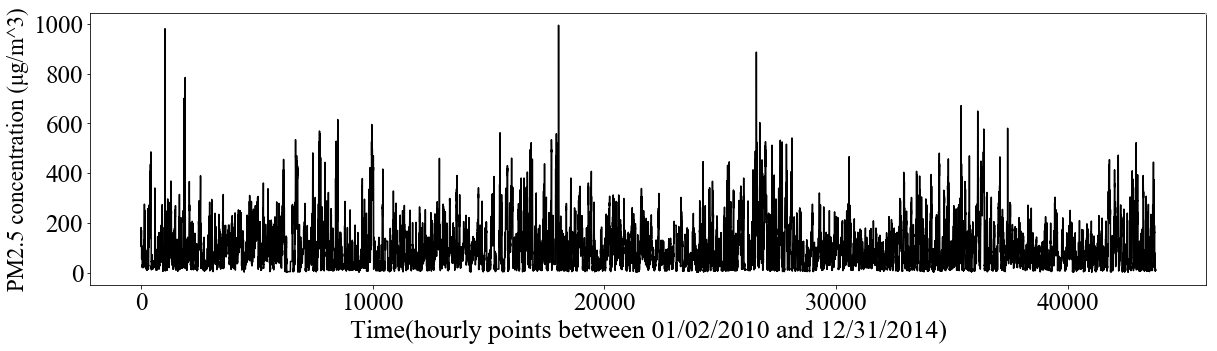

In [3]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20,5))

#调整坐标轴刻度的大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.plot(temp[0:], 'k')#, label='True value'   35041开始2014年
#plt.plot(pre_power, 'b', label='Predicted value')


# 设置图表标题并给坐标轴加上标签
plt.xlabel("Time(hourly points between 01/02/2010 and 12/31/2014)",fontsize=26)
plt.ylabel("PM2.5 concentration (μg/m^3)",fontsize=23)
#plt.title('True value and predicted value')

# 设置图例字体大小
plt.legend(fontsize=0)
plt.savefig('污染变化0723.pdf', bbox_inches='tight')
plt.show()

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
'''回调函数'''
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='B0712_lstm.model',#============保存最佳模型
        monitor='val_loss',
        save_best_only=True,
    ),
  
    keras.callbacks.ReduceLROnPlateau(  monitor='val_loss', factor=0.1, patience=20, ),
    keras.callbacks.EarlyStopping(   #============EarlyStopping
        monitor='mse',
        patience=5,
    )
]

model = Sequential()
#model.add(layers.Conv1D(40, 3, activation='relu',
#                        input_shape=(None, float_data.shape[-1])))
#model.add(layers.Dropout(0.1))
#model.add(layers.MaxPooling1D(2))
#model.add(layers.Conv1D(80, 3, activation='relu'))
#model.add(layers.Dropout(0.1))

#model.add(layers.Bidirectional(layers.GRU(80, dropout=0.2,recurrent_dropout=0.2,return_sequences = True),input_shape=(None, float_data.shape[-1])))
#model.add(layers.Bidirectional(layers.GRU(80, dropout=0.,recurrent_dropout=0.,return_sequences = True)))
#model.add(layers.Dropout(0.2))
#model.add(layers.Bidirectional(layers.GRU(80, dropout=0.2, recurrent_dropout=0.2)))

model.add(layers.GRU(500,dropout=0.0,recurrent_dropout=0.0,  input_shape=(None, float_data.shape[-1])))# return_sequences = True,
model.add(layers.Dropout(0.2))

#model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
#model.add(layers.Dense(500, activation='relu'))
#model.add(layers.LSTM(80,dropout=0.0,recurrent_dropout=0.0, activation='relu'))


#model.add(layers.Dropout(0.4))
model.add(layers.Dense(50))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=0.0005), loss='mae',metrics=['mse'])#lr=0.0005
history = model.fit_generator(train_gen,
                              steps_per_epoch=600,
                              epochs=50,
                              callbacks=callbacks_list,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 500)               762000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 787,101
Trainable params: 787,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
600/600 [==============================] - 56s 94ms/step - loss: 0.3038 - mean_squared_error: 0.2631 - val_loss: 0.2851 - val_mean_squared_error: 0.2141
Epoch 2/50
  2/600 [..............................] - ETA: 51s - loss: 0.2520 - mean_squared_error: 0.14

D:\TAO2018\Anaconda3\lib\site-packages\keras\callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


600/600 [==============================] - 55s 92ms/step - loss: 0.2810 - mean_squared_error: 0.2455 - val_loss: 0.2786 - val_mean_squared_error: 0.2114
Epoch 3/50
600/600 [==============================] - 55s 91ms/step - loss: 0.2839 - mean_squared_error: 0.2699 - val_loss: 0.2853 - val_mean_squared_error: 0.2113
Epoch 4/50
600/600 [==============================] - 54s 90ms/step - loss: 0.2782 - mean_squared_error: 0.2410 - val_loss: 0.2881 - val_mean_squared_error: 0.2246
Epoch 5/50
600/600 [==============================] - 54s 90ms/step - loss: 0.2767 - mean_squared_error: 0.2344 - val_loss: 0.2751 - val_mean_squared_error: 0.2063
Epoch 6/50
600/600 [==============================] - 54s 90ms/step - loss: 0.2752 - mean_squared_error: 0.2388 - val_loss: 0.2801 - val_mean_squared_error: 0.2054
Epoch 7/50
600/600 [==============================] - 54s 91ms/step - loss: 0.2708 - mean_squared_error: 0.2247 - val_loss: 0.2768 - val_mean_squared_error: 0.2050
Epoch 8/50
600/600 [=======

In [ ]:
model.save('LSTM0712.model')

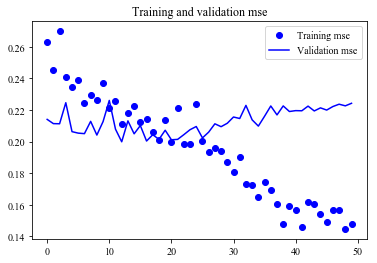

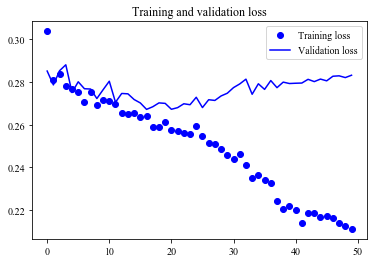

In [5]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
epochs = range(len(loss))
#画评价指标
plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
#画损失指标
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#model.save('PM25预测全连接.model')
#history.history   #查看模型返回参数
print('01 train_mae：',history.history['loss'][-1])
print('02 val_mae：',history.history['val_loss'][-1])
print('03 train_mse：',history.history['mean_squared_error'][-1])
print('04 val_mse:',history.history['val_mean_squared_error'][-1])
test_loss,test_mse = model.evaluate_generator(test_gen, 114)
print('05 test_mae:',test_loss)
print('06 test_mse:',test_mse)
print('07 lr:',history.history['lr'][-1])
model.metrics_names   #查看评价指标的名字

#history.history

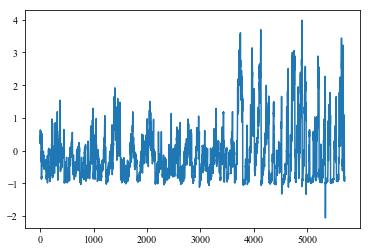

预测总长度 5700
92.52370083675247
99.22726666666667


In [3]:
from keras.models import load_model
perdict_model = load_model('B0712_lstm.model')#ANN0712.model
perdict_model.summary

pre_power = perdict_model.predict_generator(test_gen, steps = 114, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
plt.plot(pre_power)
plt.show()
print('预测总长度',len(pre_power))
print(std[1])
print(mean[1])

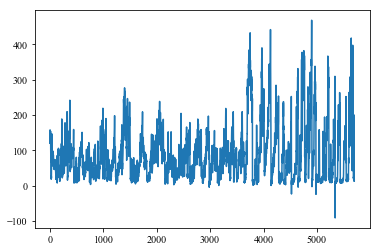

In [4]:
#***********************************还原数据******************************************#
pre_power=pre_power * std[1]
pre_power=pre_power + mean[1]
plt.plot(pre_power)
plt.show()

# 求误差 MAE MSE RMSE

In [8]:
norm_temp = float_data[:, 1]  
nttt = norm_temp[38000+68:43700+68]
ttt = temp[38000+58:43700+58]


target = ttt
prediction = pre_power

def smape(actual, predicted):
    a = np.abs(np.array(actual) - np.array(predicted))
    b = np.array(actual) + np.array(predicted)
    return 2 * np.mean(np.divide(a, b, out=np.zeros_like(a), where=b!=0, casting='unsafe'))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

error = []
for i in range(len(target)):
    error.append(target[i] - prediction[i])
  
#print("Errors: ", error)
#print(error)
  
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)#target-prediction之差平方 
    absError.append(abs(val))#误差绝对值
 
#print("Square Error: ", squaredError)
#print("Absolute Value of Error: ", absError)
 
print("MSE = ", sum(squaredError) / len(squaredError))#均方误差MSE
 
 
from math import sqrt
print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#均方根误差RMSE
print("MAE = ", sum(absError) / len(absError))#平均绝对误差MAE

print("MAPE = ", mean_absolute_percentage_error(target, prediction))#平均绝对误差MAE
print("SMAPE = ", smape(target, prediction))#平均绝对误差MAE

MSE =  237.88912280701754
RMSE =  15.42365465144424
MAE =  10.275925164473684
MAPE =  246.9317344198112
SMAPE =  0.9035867046466995


In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAPE = ", mean_absolute_percentage_error(target, prediction))#平均绝对误差MAE

# 函数：计算相关系数
def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b) 
    # 计算分子，协方差————按照协方差公式，本来要除以n的，由于在相关系数中上下同时约去了n，于是可以不除以n
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
    # 计算分母，方差乘积————方差本来也要除以n，在相关系数中上下同时约去了n，于是可以不除以n
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b])) 
    corr_factor = cov_ab/sq
    #return corr_factor
    print(corr_factor)

#http://www.itdaan.com/blog/2018/05/03/4ba16144b1f1e3177afbfa180690e9b2.html    
# 计算相关度
def computeCorrelation(x,y):
    xBar = np.mean(x)
    yBar = np.mean(y)
    SSR = 0.0
    varX = 0.0
    varY = 0.0
    for i in range(0,len(x)):
        diffXXbar = x[i] - xBar
        difYYbar = y[i] - yBar
        SSR += (diffXXbar * difYYbar)
        varX += diffXXbar**2
        varY += difYYbar**2
    SST = math.sqrt(varX * varY)
    return SSR/SST

# 计算R平方
def polyfit(x,y,degree):
    results = {}
    coeffs = np.polyfit(x,y,degree)
    results['polynomial'] = coeffs.tolist()
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat - ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['determination'] = ssreg/sstot
    return results

print('lstm:')
calc_corr(target, prediction)

MAPE =  246.9317344198112
lstm:
0.9843575384385869


# 画散点图

In [ ]:
import matplotlib.pyplot as plt

# s为点的大小
#plt.scatter(x_values,y_values,s=100)
plt.figure(figsize=(15,9))

plt.xlim(xmax=500,xmin=0)
plt.ylim(ymax=500,ymin=0)

plt.scatter(prediction,ttt,s=10,c='r')
#ttt
# 设置图表标题并给坐标轴加上标签
#plt.title("GRU",fontsize=24)
plt.xlabel("Predicted value (μg/m^3)",fontsize=26)
plt.ylabel("Observed value (μg/m^3)",fontsize=26)

# 设置刻度标记的大小
plt.tick_params(axis='both',which='major',labelsize=26)

plt.show()

In [ ]:
import numpy  
numpy.savetxt('B 7月PM25预测真实值.csv', ttt, delimiter = ',')  #注意，由于这里预测的是两个小时后的数据 真实值是从35800+58+2开始的

In [ ]:
import numpy  
numpy.savetxt('B 7月PM25预测结果ANN.csv', pre_power, delimiter = ',')

In [ ]:
import matplotlib.pyplot as plt

steps = range(len(pre_power))

plt.figure(figsize=(15,9))

#调整坐标轴刻度的大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


plt.plot(temp[38000+58:], 'r', label='True value')
plt.plot(pre_power, 'b', label='Predicted value')
#plt.plot(range(5760), temp[38000:43760], 'r', label='True value')
#plt.plot(pre_power, 'b', label='predicted value')

# 设置图表标题并给坐标轴加上标签
plt.xlabel("Time(h)",fontsize=26)
plt.ylabel("PM2.5 concentration (μg/m^3)",fontsize=26)
#plt.title('True value and predicted value')

# 设置图例字体大小
plt.legend(fontsize=26)

plt.show()

# 画局部放大图

In [ ]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

def f1(t):
    return np.exp(-t)*np.cos(2*np.pi*t)

def f11(t):
    return np.exp(-t)*np.cos(2*np.pi*t+0.2)

def f111(t):
    return np.exp(-t+0.2)*np.cos(2*np.pi*t)

t = np.arange(0.0,5.0,0.02)

plt.figure(figsize=(16,8),dpi=98)
p1 = plt.subplot(121,aspect=5/2.5)
p2 = plt.subplot(122,aspect=0.5/0.05)

label_f0 = r"$f(t)=e^{-t+\alpha} \cos (2 \pi t+\beta)$"
label_f1 = r"$\alpha=0,\beta=0$"
label_f11 = r"$\alpha=0,\beta=0.2$"
label_f111 = r"$\alpha=0.2,\beta=0$"

p1.plot(t,f1(t),"g",label=label_f1,linewidth=2)
p1.plot(t,f11(t),"r-.",label=label_f11,linewidth=2)
p1.plot(t,f111(t),"b:",label=label_f111,linewidth=2)
p2.plot(t,f1(t),"g",label=label_f1,linewidth=2)
p2.plot(t,f11(t),"r-.",label=label_f11,linewidth=2)
p2.plot(t,f111(t),"b:",label=label_f111,linewidth=2)

p1.axis([0.0,5.01,-1.0,1.5])

p1.set_ylabel("v",fontsize=14)
p1.set_xlabel("t",fontsize=14)
#p1.set_title("A simple example",fontsize=18)
p1.grid(True)
p1.legend()

tx = 0.5
ty = 0.9
p1.text(tx,ty,label_f0,fontsize=15,verticalalignment="top",horizontalalignment="left")

p2.axis([4,4.5,-0.02,0.03])
p2.set_ylabel("v",fontsize=14)
p2.set_xlabel("t",fontsize=14)
p2.grid(True)
p2.legend()

# plot the box
tx0 = 4
tx1 = 4.5
ty0 = -0.1
ty1 = 0.1
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
p1.plot(sx,sy,"purple")

# plot patch lines
xy=(4.45,0.09)
xy2 = (4.02,0.026)
con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
        axesA=p2,axesB=p1)
p2.add_artist(con)

xy = (4.45,-0.09)
xy2 = (4.02,-0.018)
con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
        axesA=p2,axesB=p1)
p2.add_artist(con)

plt.show()

In [ ]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(range(1000), temp[39000+58:40000+58], 'r', label='True value')   #    加上一个batch size  再加一个滞后 delay +lookback
plt.plot(pre_power[1000:2000], 'b', label='predicted value')
plt.title('True value and predicted value')
plt.legend()

plt.show()

In [ ]:
plt.figure()
plt.plot(range(500), temp[39000+58:39500+58], 'r', label='True value')   #    加上一个batch size  再加一个滞后 delay
plt.plot(pre_power[1000:1500], 'b', label='predicted value')
plt.title('True value and predicted value')
plt.legend()

plt.show()

In [ ]:
plt.figure()
plt.plot(range(200), temp[39100+58:39300+58], 'r', label='True value')   #    加上一个batch size  再加一个滞后 delay
plt.plot(pre_power[1100:1300], 'b', label='predicted value')
plt.title('True value and predicted value')
plt.legend()

plt.show()

## Wrapping up

Here's what you should take away from this section:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing 
temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` 
layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D 
convnet as a preprocessing step before a RNN, shortening the sequence and extracting useful representations for the RNN to process.

One useful and important concept that we will not cover in these pages is that of 1D convolution with dilated kernels.

In [ ]:
import matplotlib.pyplot as plt

steps = range(len(pre_power))

plt.figure(figsize=(15,9))

#调整坐标轴刻度的大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)



plt.plot(temp[38000+58:], 'r', label='True value', linewidth = 1)
plt.plot(pre_power, 'b:', label='Predicted value', linewidth = 2)
#plt.plot(pre_power, 'b', label='Predicted value')
#plt.plot(range(5760), temp[38000:43760], 'r', label='True value')
#plt.plot(pre_power, 'b', label='predicted value')

# 设置图表标题并给坐标轴加上标签
#plt.xlabel("Hourly points(05/04/2014-12/31/2014)",fontsize=26)
plt.xlabel("Hourly points(05/06/2014-12/30/2014)",fontsize=26)
plt.ylabel("PM2.5 concentration (μg/m^3)",fontsize=26)
#plt.title('True value and predicted value')

# 设置图例字体大小
plt.legend(fontsize=26)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

steps = range(len(pre_power))

plt.figure(figsize=(30,9))

#调整坐标轴刻度的大小
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)



plt.plot(temp[38000+58:], 'r', label='True value', linewidth = 1.5)
plt.plot(pre_power, 'b:', label='Predicted value', linewidth = 2.5)
#plt.plot(pre_power, 'b', label='Predicted value')
#plt.plot(range(5760), temp[38000:43760], 'r', label='True value')
#plt.plot(pre_power, 'b', label='predicted value')

# 设置图表标题并给坐标轴加上标签
#plt.xlabel("Hourly points(05/04/2014-12/31/2014)",fontsize=26)
plt.xlabel("Hourly points(05/06/2014-12/30/2014)",fontsize=26)
plt.ylabel("PM2.5 concentration (μg/m^3)",fontsize=26)
#plt.title('True value and predicted value')

# 设置图例字体大小
plt.legend(fontsize=26)

plt.show()